## SwarmUI API + Ollama Tool Calling

Before you can make the api request, you need to set up the backend. This should be completed wherever you want the SwarmUI package to be. A notebook isnt neccesarily the best way to do this long term. 

### Linux Install

In [ ]:
!wget https://github.com/mcmonkeyprojects/SwarmUI/releases/download/0.6.5-Beta/install-linux.sh -O install-linux.sh
%chmod +x install-linux.sh

Then open a new terminal in the SwarmUI directory (outside of this notebook) and run the install command. Make sure to download the flux1 schnell fp8 weights as part of the install. It makes the whole process much easier. 

In [ ]:
!./install-linux.sh

If you already have SwarmUI installed, use this in your existing installation directory:

In [ ]:
./launch-linux.sh

### Windows or Docker Install

Refer to the documentation in [mcmonkeyprojects/SwarmUI](https://github.com/mcmonkeyprojects/SwarmUI)

## Setup the API Backend

Once you have completed the setup and downloaded the flux1 schnell fp8 weights, you will navigate to `Server > Backends`

![path](assets/nav-path.png)

Then start the API Backend and select your preferences. If this if your first time using swarm UI then my settings are probably fine. 

![api-backend](assets/api-screenshot.png)

## Standard Request Structure w/o Ollama

_Strongly reccommend reading the documentation available on [github](https://github.com/mcmonkeyprojects/SwarmUI/tree/master/docs)_

The first componenet to making a Swarm UI API request is obtaining a session id

In [18]:
import requests
import json
from PIL import Image
from io import BytesIO
from IPython.display import display
# # Define the URL for obtaining a session ID
session_url = "http://localhost:7801/API/GetNewSession"
session_response = requests.post(session_url, headers={"Content-Type": "application/json"}, data="{}")


# Check if the request was successful
if session_response.status_code == 200:
    session_data = session_response.json()
    session_id = session_data.get("session_id")
    print(f"Session ID obtained: {session_id}")
else:
    print(f"Failed to obtain session ID. Status code: {session_response.status_code}")
    print(f"Response: {session_response.text}")


Session ID obtained: 75DF720DCC2CDA908F713CF22062B4574505E080


Once you have a session id, you can use it to access other parts of the API, like the paramater list for settings that can be changed

In [19]:
import requests
import json

# Define the URL for fetching T2I parameters
list_params_url = "http://localhost:7801/API/ListT2IParams"

# Define the payload
payload = {
    "session_id": session_id
}

# Make the POST request to retrieve the parameters
response = requests.post(list_params_url, headers={"Content-Type": "application/json"}, data=json.dumps(payload))

# Check if the request was successful
if response.status_code == 200:
    try:
        # Parse the JSON response
        params_data = response.json()
        print("T2I Parameters retrieved successfully.")
        
        # Display the parameters in a readable format
        for param in params_data.get('list', []):
            print(f"Name: {param['name']}")
            print(f"ID: {param['id']}")
            print(f"Description: {param['description']}")
            print(f"Type: {param['type']}")
            print(f"Default: {param['default']}")
            print(f"Min: {param['min']}, Max: {param['max']}")
            print(f"Values: {param.get('values', 'N/A')}")
            print(f"Examples: {param.get('examples', 'N/A')}")
            print(f"Visible: {param['visible']}")
            print(f"Advanced: {param['advanced']}")
            print(f"Toggleable: {param['toggleable']}")
            print(f"Priority: {param['priority']}")
            print(f"Group Name: {param['group']['name'] if param.get('group') else 'N/A'}")
            print('-' * 40)

        # Display models
        models = params_data.get('models', {})
        print("\nAvailable Models:")
        for model_type, model_list in models.items():
            print(f"{model_type}: {', '.join(model_list)}")

        # Display wildcards
        wildcards = params_data.get('wildcards', [])
        print("\nAvailable Wildcards:")
        print(", ".join(wildcards))

    except json.JSONDecodeError as e:
        # Handle JSON parsing errors
        print("Failed to parse JSON response:", e)
        print("Raw response content:", response.text)
else:
    print(f"Failed to retrieve T2I parameters. Status code: {response.status_code}")
    print(f"Response: {response.text}")


T2I Parameters retrieved successfully.
Name: [Grid Gen] Prompt Replace
ID: gridgenpromptreplace
Description: Replace text in the prompt (or negative prompt) with some other text.
Type: text
Default: 
Min: 0.0, Max: 0.0
Values: None
Examples: None
Visible: False
Advanced: False
Toggleable: True
Priority: 10.0
Group Name: N/A
----------------------------------------
Name: [Grid Gen] Presets
ID: gridgenpresets
Description: Apply parameter presets to the image. Can use a comma-separated list to apply multiple per-cell, eg 'a, b || a, c || b, c'
Type: dropdown
Default: 
Min: 0.0, Max: 0.0
Values: []
Examples: None
Visible: False
Advanced: False
Toggleable: True
Priority: 10.0
Group Name: N/A
----------------------------------------
Name: Prompt
ID: prompt
Description: The input prompt text that describes the image you want to generate.
Tell the AI what you want to see.
Type: text
Default: 
Min: 0.0, Max: 0.0
Values: None
Examples: ['a photo of a cat', 'a cartoonish drawing of an astronaut']

The Flux1 model requires a cfgscale of around 1 and does not accept a negative prompt. The efficient window for generating high quality images is between 1 and 4 steps.

Image generated successfully.
Response data: {'images': ['View/local/raw/2024-08-30/1538-a picture of a cat-Fluxflux1-schnell-fp8-1745872672.png']}


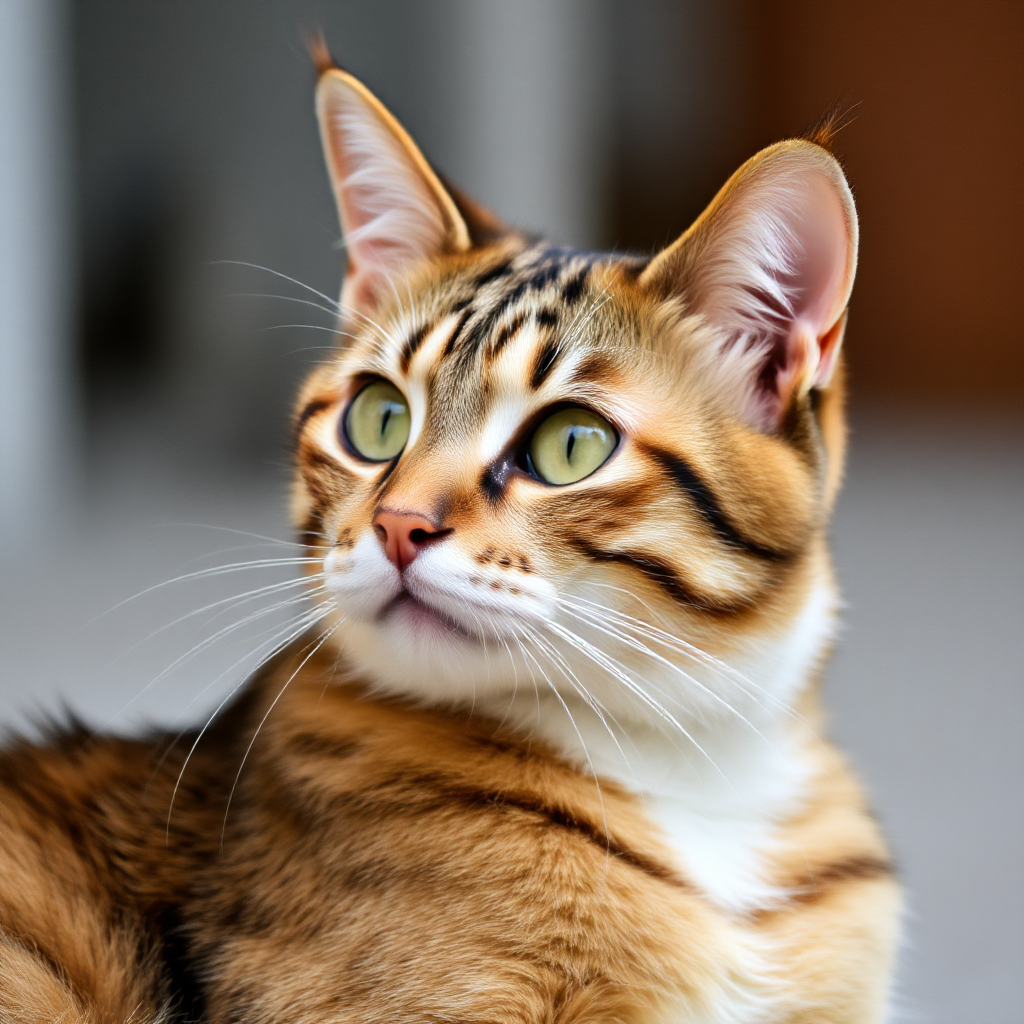

In [32]:
import requests
import json
from PIL import Image
from io import BytesIO
from IPython.display import display

url = "http://localhost:7801/API/GenerateText2Image"

# Define the parameters for the request
payload = {
    "session_id": session_id,
    "model": "Flux/flux1-schnell-fp8",
    "images": 1,  # The number of images to generate
    "prompt": "a picture of a cat",
    "width": 1024,  # Image width
    "height": 1024,  # Image height,
    "steps": 2,
    "cfgscale": 1.0,
    
}

# Make the request to generate the image
generate_response = requests.post(url, headers={"Content-Type": "application/json"}, data=json.dumps(payload))
# Check if the request was successful
# Check if the request was successful
if generate_response.status_code == 200:
    try:
        # Attempt to parse JSON response
        generate_data = generate_response.json()
        print("Image generated successfully.")
        print("Response data:", generate_data)
        
        # Extract the image path
        image_path = generate_data['images'][0]
        
        # The path might be relative, so you need to prepend the base URL
        image_full_path = f"http://localhost:7801/{image_path}"
        
        # Download the image
        image_response = requests.get(image_full_path)
        image_response.raise_for_status()

        # Open the image using Pillow
        img = Image.open(BytesIO(image_response.content))
        
        # Display the image in the notebook
        display(img)

    except json.JSONDecodeError as e:
        # Handle JSON parsing errors
        print("Failed to parse JSON response:", e)
        print("Raw response content:", generate_response.text)
    except Exception as e:
        # Handle any other exceptions
        print("An error occurred:", e)
else:
    print(f"Failed to generate image. Status code: {generate_response.status_code}")
    print(f"Response: {generate_response.text}")

In [22]:
import requests
import json
from PIL import Image
from io import BytesIO

class SwarmUIRequest:
    def __init__(self, session_id=None, base_url="http://localhost:7801"):
        self.base_url = base_url
        self.session_id = session_id
        if session_id:
            self.session_id = session_id
            print(f"Using provided session ID: {self.session_id}")
        else:
            self.session_id = self.get_session_id()

    def get_session_id(self):
        session_url = f"{self.base_url}/API/GetNewSession"
        response = requests.post(session_url, headers={"Content-Type": "application/json"}, data="{}")
        
        if response.status_code == 200:
            session_data = response.json()
            session_id = session_data.get("session_id")
            print(f"Session ID obtained: {session_id}")
            return session_id
        else:
            print(f"Failed to obtain session ID. Status code: {response.status_code}")
            print(f"Response: {response.text}")
            exit()

    def generate_image(self, model, prompt, images=1, width=1024, height=1024, steps=2, cfgscale=1.0):
        url = f"{self.base_url}/API/GenerateText2Image"
        payload = {
            "session_id": self.session_id,
            "model": model,
            "images": images,
            "prompt": prompt,
            "width": width,
            "height": height,
            "steps": steps,
            "cfgscale": cfgscale,
        }
        
        response = requests.post(url, headers={"Content-Type": "application/json"}, data=json.dumps(payload))
        
        if response.status_code == 200:
            try:
                return response.json()
            except json.JSONDecodeError as e:
                print("Failed to parse JSON response:", e)
                print("Raw response content:", response.text)
                return None
        else:
            print(f"Failed to generate image. Status code: {response.status_code}")
            print(f"Response: {response.text}")
            return None
    
    def display_image(self, image_path):
        image_full_path = f"{self.base_url}/{image_path}"
        
        try:
            image_response = requests.get(image_full_path)
            image_response.raise_for_status()
            img = Image.open(BytesIO(image_response.content))
            return img
        except Exception as e:
            print(f"An error occurred while fetching the image: {e}")
            return None
    
    def run(self, model, prompt):
        result = self.generate_image(model, prompt)
        if result:
            # Check if 'images' key exists in the result
            if 'images' in result:
                image_path = result['images'][0]
                return self.display_image(image_path)
            else:
                print(f"Error: 'images' key not found in the response. Full response: {result}")
                return None
        else:
            print("Error: No result returned from generate_image.")
            return None


# # Example usage
# if __name__ == "__main__":
#     # If you have an existing session ID, pass it here
#     existing_session_id = "42698B9E8E9A7B6BB93883EB796A0DA7B6C69079"
    
#     generator = ImageGenerator(session_id=existing_session_id)
#     generator.run(model="Flux/flux1-schnell-fp8", prompt="a picture of a cat")


This function will generate a new session ID for every request. If you use this notebook in your own application you will want to add a function to handle your sessions in whatever platform you are using. e.g. Streamlit, gradio, etc. 

In [23]:
def query_swarm(model, prompt, session_id=None):
    # Initialize SwarmUIRequest with the provided session_id if it exists, otherwise, it will generate a new one
    swarm = SwarmUIRequest(session_id=session_id)
    
    # Use the existing or newly generated session ID for generating the image
    return swarm.run(model=model, prompt=prompt)


### session id example
# def query_swarm(model, prompt):
#     # If no session ID exists in session state, create a new one
#     if st.session_state.session_id is None:
#         swarm = SwarmUIRequest()  # This will generate a new session ID
#         st.session_state.session_id = swarm.session_id
#     else:
#         swarm = SwarmUIRequest(session_id=st.session_state.session_id)
    
#     # Use the session ID stored in session state
#     return swarm.run(model=model, prompt=prompt)

Session ID obtained: 214CEFFE9C88A31346AD86B090B6CBF711E6C37E


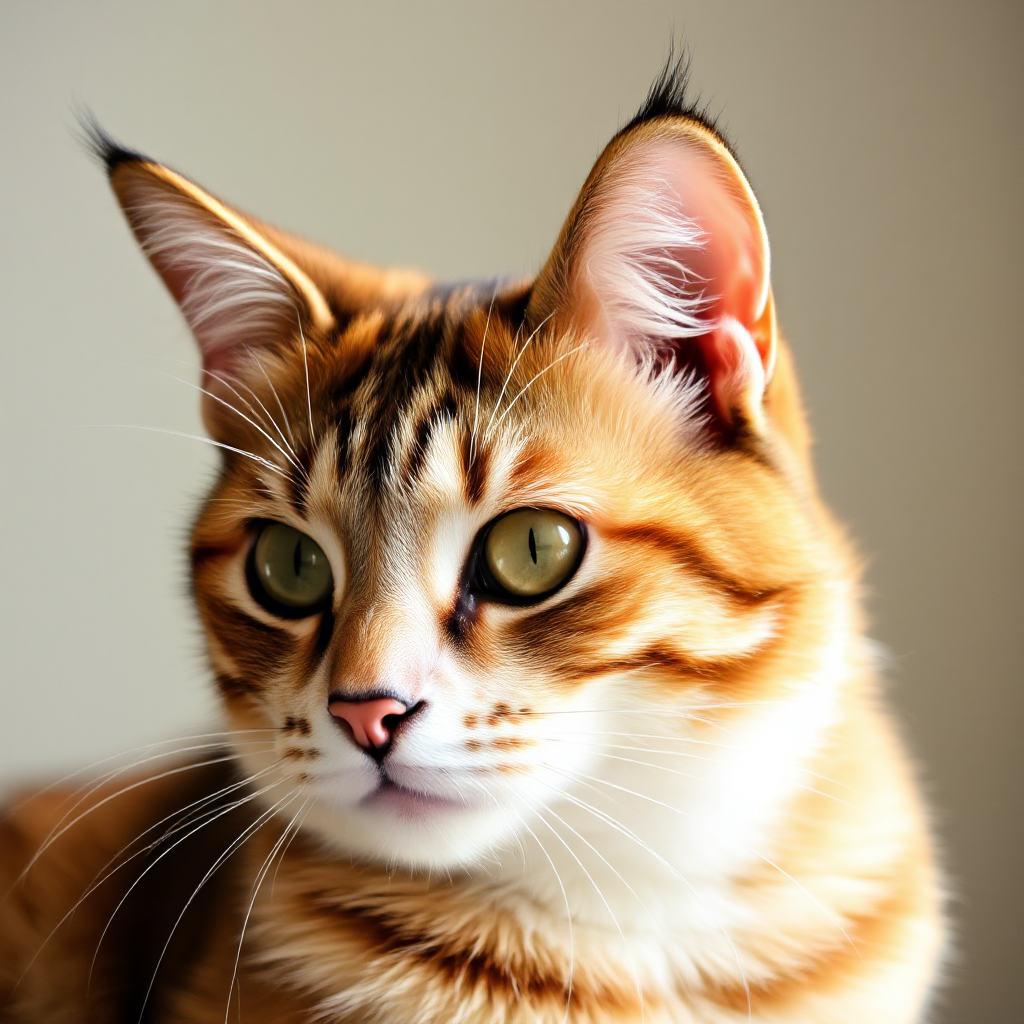

In [24]:
# Test the function outside of ollama
query_swarm(model="Flux/flux1-schnell-fp8", prompt="a picture of a cat")

Due to the efficient caching mechanisms utilized in SwarmUI, the first generation will be comparable to the methods described in the litserve notebook, but the above generations are completed in ~ 2(s)

## Generation with ollama tool calling

This allows you to utilize the same API for any models you have loaded into swarm UI rather than needing to have multiple dedicated servers through litserve. 

In [32]:
import ollama


# Initialize model and messages
model = 'llama3.1'
diffuser_model = 'Flux/flux1-schnell-fp8'
# System message guiding the model's behavior
system_message = {
    'role': 'system',
    'content': 'You are an AI assistant that can generate images based on text prompts.'
}

prompt = "can you generate me a cute kitty"

# User message
user_message = {
    'role': 'user',
    'content': prompt
}

# Initialize conversation with the system message and user query
messages = [system_message, user_message]

# We can reuse the same tool call definition as the litserve notebook
tools = [
    {
        'type': 'function',
        'function': {
            'name': 'query_swarm',
            'description': 'Generates an image based on a text prompt and returns the result.',
            'parameters': {
                'type': 'object',
                'properties': {
                    'prompt': {
                        'type': 'string',
                        'description': 'The text prompt to generate the image from.',
                    },
                },
                'required': ['prompt'],
            },
        },
    }
]

# Model sends the query and decides to use the `query_flux` tool
response = ollama.chat(
    model=model,
    messages=messages,
    tools=tools
)

# Append the model's response to the existing messages
messages.append(response['message'])

The model used the following functions:
[{'function': {'name': 'query_swarm', 'arguments': {'prompt': 'a cute kitty'}}}]
Session ID obtained: 0A81FEBA28DAF6F1AE72565EA74495EE2F761210


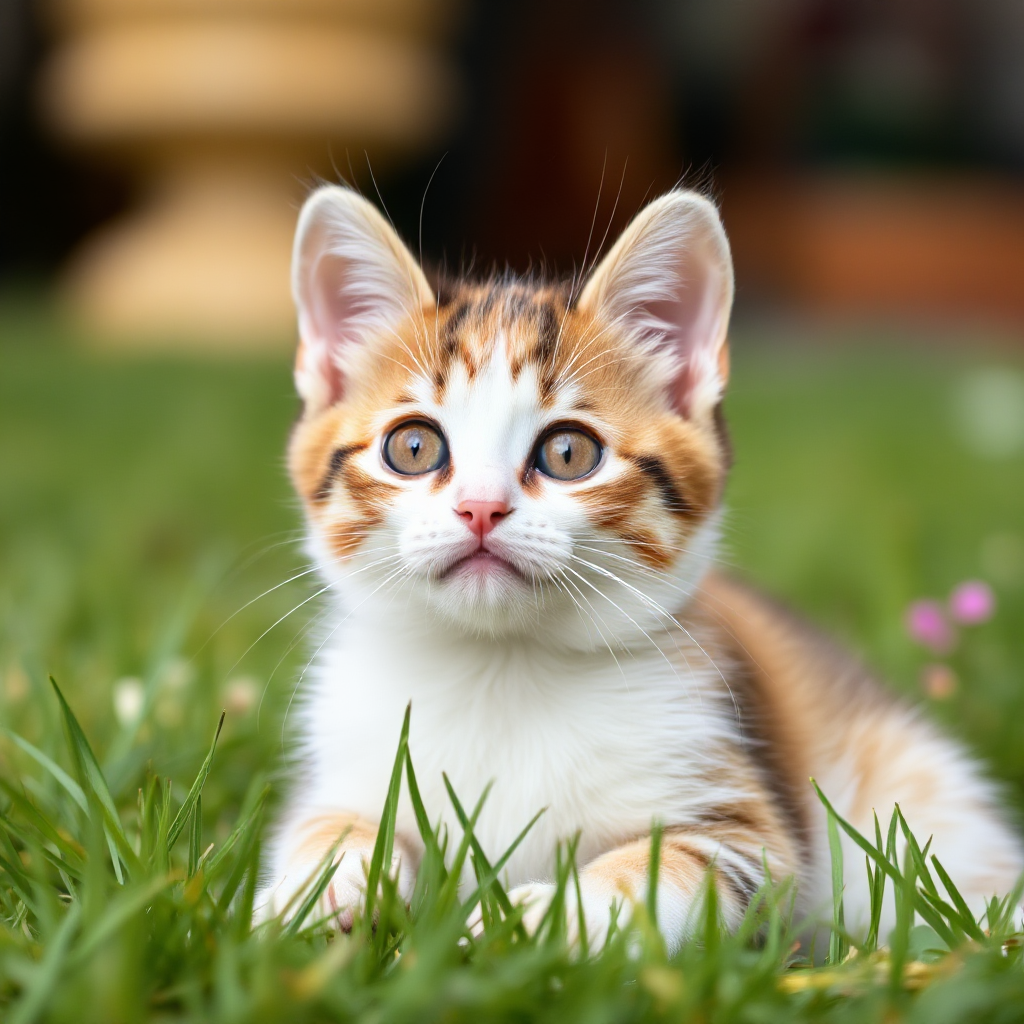

Image generated and displayed for prompt: 'a cute kitty'


In [33]:

# from here until the end its the same as the litserve notebook
# the only thing changed is `query_flux` to `query_swarm`

if not response['message'].get('tool_calls'):
    print("The model didn't use any function. Its response was:")
    print(response['message']['content'])
else:
    print("The model used the following functions:")
    print(response['message']['tool_calls'])
    # Process the tool call
    tool_call = response['message']['tool_calls'][0]
    function_name = tool_call['function']['name']
    prompt = tool_call['function']['arguments']['prompt']
    

if function_name == 'query_swarm':
    # Call the query_swarm function with the extracted prompt
    image = query_swarm(diffuser_model, prompt)
    
    if image:
        display(image)
        print(f"Image generated and displayed for prompt: '{prompt}'")
    else:
        print(f"Failed to generate image for prompt: '{prompt}'")


You can add more paramaters to the request and change whatever you want without changing the structure of the tool call. 

Additionally, in this example, any swarm UI model and configuration can be used. The model could theoretically select which ComfyUI config it wanted to use to complete the generation. Albeit unreliable, it can still be done. Which is a huge step forward for open source AI.

If you enjoyed this, feel free to check out the UI that has this code integrated:

https://www.github.com/tdolan21/tool-calling-playgrounds